# Get Data from Wikipedia

I follow the tutorial at https://www.mediawiki.org/wiki/API:Tutorial. I decided to use the url for wikipedia since that way I have obtained more results (at least 200 different data records needed)

In [1]:
import pandas as pd

url = 'https://en.wikipedia.org/w/api.php'

In [2]:
params = {
    "action": "query",
    "list": "mostviewed", # get most viewed articles
    "pvimlimit": 20, # limit the result to 200
    "format" : "json"
}

In [3]:
import requests
r = requests.get(url, params=params)
print(r)

<Response [200]>


In [4]:
r.json()

{'batchcomplete': '',
 'continue': {'pvimoffset': 20, 'continue': '-||'},
 'query': {'mostviewed': [{'ns': 0, 'title': 'Main Page', 'count': 6431418},
   {'ns': -1, 'title': 'Special:Search', 'count': 1287435},
   {'ns': 0, 'title': 'Halloween', 'count': 558327},
   {'ns': 0, 'title': 'Luiz Inácio Lula da Silva', 'count': 407699},
   {'ns': 0, 'title': 'Charles Cullen', 'count': 260345},
   {'ns': 0, 'title': '2022 Brazilian general election', 'count': 231960},
   {'ns': 0, 'title': 'XXX: Return of Xander Cage', 'count': 228911},
   {'ns': 0, 'title': 'Jeffrey Dahmer', 'count': 225417},
   {'ns': 0, 'title': 'Jair Bolsonaro', 'count': 192926},
   {'ns': 0, 'title': 'Cleopatra', 'count': 185872},
   {'ns': 0, 'title': 'YouTube', 'count': 185498},
   {'ns': 4, 'title': 'Wikipedia:Featured pictures', 'count': 175038},
   {'ns': 0, 'title': 'Elon Musk', 'count': 158065},
   {'ns': 0, 'title': "ICC Men's T20 World Cup", 'count': 152605},
   {'ns': 0, 'title': 'Kantara (film)', 'count': 1516

In [5]:
# Get titles:
article_titles = []
article_views = []
for idx, x in enumerate(r.json()['query']['mostviewed']):
    # I will not include the pages "Main Page" and "Special:Search".
    if (x['title'] != 'Main Page' and x['title'] != 'Special:Search'):
        article_titles.append(x['title'])
        article_views.append(x['count'])

In [6]:
import pandas as pd
df = pd.DataFrame(columns=['Title', 'Text', 'Views'])
df['Title'] = article_titles
df['Views'] = article_views
df.head()

,Title,Text,Views
0,Halloween,NaN,558327
1,Luiz Inácio Lula da Silva,NaN,407699
2,Charles Cullen,NaN,260345
3,2022 Brazilian general election,NaN,231960
4,XXX: Return of Xander Cage,NaN,228911


In [7]:
# Create a scrapper:
from bs4 import BeautifulSoup
import re

def getWikiText(html_txt):
    soup = BeautifulSoup(html_txt, 'html.parser')
    # we are interested in those that are tagged as <p> which stands for paragraphs.
    text = ''
    for paragraph in soup.find_all('p'):
        text += paragraph.text
        # Let’s do a little bit of cleaning to get the exact output from the previous section
    text = re.sub(r'\[.*?\]+', '', text)
    text = text.replace('\n', '')
    return text


In [8]:
# Request the article for each page:

for idx, title in enumerate(df['Title']):
    params = {
        "action": "parse",
        "prop": "text",
        "page": title,
        "format" : "json"
    }
    try:
        request = requests.get(url, params=params)
        if request.status_code != 200:
            raise Exception(f"Download failed with code {request.status_code}")
        else:
            df.at[idx, 'Text']= getWikiText(request.json()['parse']['text']['*'])
    except Exception as e:
        print(e)

In [9]:
df.head()

,Title,Text,Views
0,Halloween,Halloween or Hallowe'en (less commonly known a...,558327
1,Luiz Inácio Lula da Silva,Luiz Inácio Lula da Silva (Brazilian Portugues...,407699
2,Charles Cullen,"Charles Edmund Cullen (born February 22, 1960)...",260345
3,2022 Brazilian general election,Jair BolsonaroPLLuiz Inácio Lula da SilvaPTGen...,231960
4,XXX: Return of Xander Cage,XXX: Return of Xander Cage (released as XXX: R...,228911


In [10]:
df.to_csv('most_watched_wiki_articles.csv')

# Statistic representation

## Article lengths

In [14]:
# Get Lengths of text
for idx, article in enumerate(df['Text']):
  df.at[idx, 'Length'] = len(article)

TypeError: ignored

<Figure size 7200x7200 with 0 Axes>

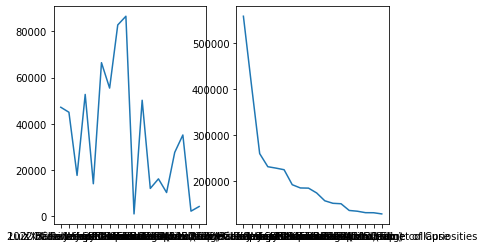

In [50]:
import seaborn as sns
plt.figure(figsize=(100,100))

fig, (pic1, pic2) = plt.subplots(1, 2)

pic1.plot(df['Title'], df['Length'])
pic2.plot(df['Title'], df['Views'])

plt.show()


## Articles Views:

## Create a Word Cloud for the 9 most watched

Source: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

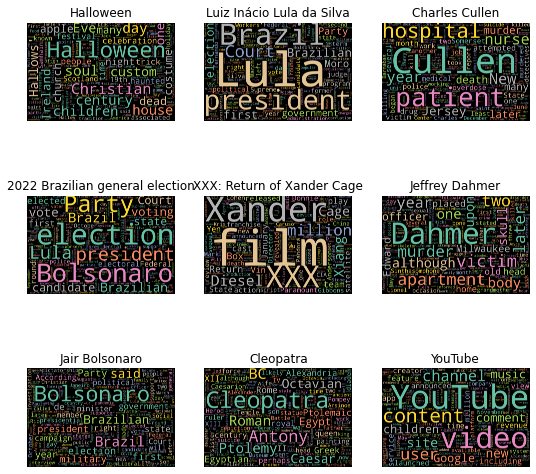

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))

for idx, text in enumerate(df['Text'][0:9]): 
  plt.subplot(3, 3, idx+1)
  wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  plt.imshow(wordcloud)
  plt.title(f"{df['Title'].iloc[idx]}")
  plt.axis('off')